In [1]:
import os
import pandas as pd 
import numpy as np 

from typing import Dict, List

from femr.models.dataloader import BatchLoader
from femr.datasets import PatientDatabase

from src.default_paths import path_root, path_extract
from src.utils import get_best_clmbr_model 
from src.io import read_msgpack 

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

In [7]:
path_save = os.path.join(path_root, "results/figures/supplementary/")
os.makedirs(path_save, exist_ok=True)

### PART 1. Code Coverage
To calculate code coverage stratified by code type (code only, numeric, categorical), we are iterating overing each patient timeline to obtain the number of coded events covered / not covered by the mimic / Stanford CLMBR dictionary. 

We are going to use the `BatchLoader` class from FEMR to do this. For each `batch`, `batch["transformer"]["tokens"]` is an array of `int` that contains indices of all coded events in the CLMBR dictionary. `batch["transformer"]["valid_tokens"]` is an array of `bool` that specifies whether each coded event can be indexed, i.e., whether the coded event can be indexed to an item in the dictionary.

Code type is stored in the dictionary item as `item["type"]`, where type 0 is `code only`, 1 is `numerics`, and 2 is `categorical`. 

In [2]:
mimic_model_path = get_best_clmbr_model(os.path.join(path_root, "data/clmbr_models/clmbr_mimic"))
mimic_info_path = os.path.join(
    path_root, "data/clmbr_models/clmbr_mimic", 
    mimic_model_path, 
    "clmbr_batches/batch_info.msgpack"
)

stanford_model_path = get_best_clmbr_model(os.path.join(path_root, "data/clmbr_models/clmbr_stanford_cp"))
stanford_info_path = os.path.join(
    path_root, 
    "data/clmbr_models/clmbr_stanford_cp", 
    stanford_model_path, 
    "clmbr_batches/batch_info.msgpack"
)

mimic_dict_path = os.path.join(path_root, "data/clmbr_models/clmbr_mimic", mimic_model_path, "dictionary")
stanford_dict_path = os.path.join(path_root, "data/clmbr_models/clmbr_stanford_cp", stanford_model_path, "dictionary")

model_paths = {
    "clmbr_mimic": {
        "batch_info_path": mimic_info_path,
        "dictionary_path": mimic_dict_path,
    },
    "clmbr": {
        "batch_info_path": stanford_info_path,
        "dictionary_path": stanford_dict_path,
    },
}

#### Count of patients and coded event coverage in batches stratified by code type

In [3]:
def get_coverage_by_type(
    clmbr_dict: List[Dict],
    token_indices: np.ndarray[int],
    valid_tokens: np.ndarray[bool], 
    token_type: int,
):

    tokens = [clmbr_dict[x] for x in token_indices]
    valid_tokens = [clmbr_dict[x] for x in token_indices[valid_tokens]]

    num_total, num_covered = 0, 0
    
    for token in tokens:
        if token["type"] == token_type:
            num_total += 1

    for token in valid_tokens:
        if token["type"] == token_type:
            num_covered += 1

    return num_total, num_covered


In [4]:
df = pd.DataFrame()

for model, paths in model_paths.items():
    clmbr_dict = read_msgpack(paths["dictionary_path"])["regular"]

    total_codes, total_codes_covered = 0, 0
    total_codes_0, total_codes_0_covered = 0, 0
    total_codes_1, total_codes_1_covered = 0, 0
    total_codes_2, total_codes_2_covered = 0, 0
    total_patients, total_indices = 0, 0

    loader = BatchLoader(path_extract, paths["batch_info_path"])
    for dataset in ["train", "dev", "test"]:
        for i in range(loader.get_number_of_batches(dataset)):
            batch = loader.get_batch(dataset, i)
            total_codes += len(batch["transformer"]["tokens"])
            total_codes_covered += sum(batch["transformer"]["valid_tokens"])
            total_indices += batch["num_indices"]
            total_patients += batch["num_patients"]

            num_codes_0, num_codes_0_covered = get_coverage_by_type(
                clmbr_dict, 
                batch["transformer"]["tokens"], 
                batch["transformer"]["valid_tokens"], 
                0
            )
            total_codes_0 += num_codes_0 
            total_codes_0_covered += num_codes_0_covered

            num_codes_1, num_codes_1_covered = get_coverage_by_type(
                clmbr_dict, 
                batch["transformer"]["tokens"], 
                batch["transformer"]["valid_tokens"], 
                1
            )
            total_codes_1 += num_codes_1 
            total_codes_1_covered += num_codes_1_covered    

            num_codes_2, num_codes_2_covered = get_coverage_by_type(
                clmbr_dict, 
                batch["transformer"]["tokens"], 
                batch["transformer"]["valid_tokens"], 
                2
            )
            total_codes_2 += num_codes_2 
            total_codes_2_covered += num_codes_2_covered 

    df = pd.concat((
        df,
        pd.DataFrame({
            "model": [model],
            "total_patients": total_patients,
            "total_indices": total_indices,
            "total_codes": total_codes,
            "total_codes_covered": total_codes_covered,
            "total_codes_only": total_codes_0,
            "total_codes_only_covered": total_codes_0_covered, 
            "total_numerics": total_codes_1,
            "total_numerics_covered": total_codes_1_covered,
            "total_categoricals": total_codes_2,
            "total_categoricals_covered": total_codes_2_covered,
        })
    ))

When mapping codes, dropped 0 out of 32768
When mapping codes, dropped 36666 out of 65536


{'total_codes_only_lost': 0.372, 'total_numerics_lost': 0.233, 'total_categoricals_lost': 0.91}


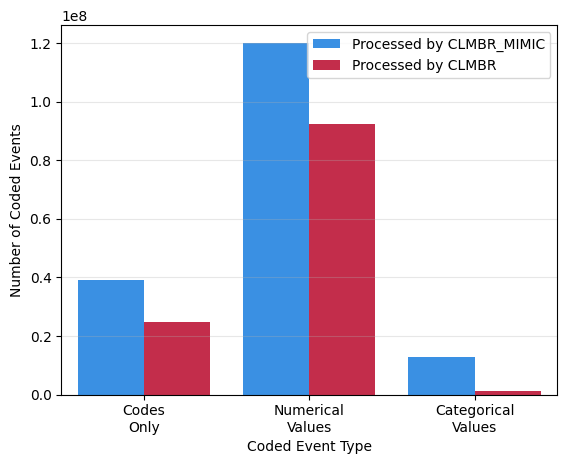

In [8]:
data = df[["model", "total_codes_only_covered", "total_numerics_covered", "total_categoricals_covered"]]
data = data.melt(id_vars="model")

# calculate lost information
clmbr_values = (
    data.query("model=='clmbr'")[["variable","value"]]
    .set_index("variable")
    .to_dict()
    ["value"]
)

clmbr_sk_values = (
    data.query("model=='clmbr_mimic'")
    [["variable","value"]]
    .set_index("variable")
    .to_dict()
    ["value"]
)

info_loss = {x.replace("covered","lost"):round(1-clmbr_values[x]/clmbr_sk_values[x],3) for x in clmbr_values}

print(info_loss)

data = data.replace({
    "clmbr": "Processed by CLMBR",
    "clmbr_mimic": "Processed by CLMBR_MIMIC",
    "total_codes_only_covered": "Codes\nOnly",
    "total_numerics_covered": "Numerical\nValues",
    "total_categoricals_covered": "Categorical\nValues"
})

ax = sns.barplot(
    data = data,
    x = "variable",
    y = "value", 
    hue = "model", 
    palette = {
        "Processed by CLMBR_MIMIC": 'dodgerblue', 
        "Processed by CLMBR": 'crimson',
    }
)

ax.set_xlabel("Coded Event Type")
ax.set_ylabel("Number of Coded Events")
ax.legend_.set_title(None)

plt.grid(axis="y", alpha=0.3)

plt.savefig(
    os.path.join(path_save, "code_coverage.png"), 
    dpi=300, bbox_inches='tight', pad_inches=0.2
)

plt.show()

### Part 2. Numerical Distributions

Here we look at differences in numerical distributions between SickKids and Stanford data. The distributions are stored in the CLMBR dictionary for coded events with type 1. Below we obtain the common set of numerical items between mimic and CLMBR dictionaries and plot their distributions. For brevity we only look at the first 10 common items. 

In [9]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [19]:
# codes in all 3 CLMBR dictionaries
codes = [
    'LOINC/10378-8', 'LOINC/11253-2', 'LOINC/14196-0', 'LOINC/14979-9', 'LOINC/1920-8',
    'LOINC/1925-7', 'LOINC/1994-3', 'LOINC/2019-8', 'LOINC/2028-9', 'LOINC/2069-3',
    'LOINC/2075-0', 'LOINC/2093-3', 'LOINC/21000-5', 'LOINC/2276-4', 'LOINC/2324-2',
    'LOINC/2703-7', 'LOINC/2744-1', 'LOINC/2823-3', 'LOINC/2947-0', 'LOINC/2951-2',
    'LOINC/30522-7', 'LOINC/3243-3', 'LOINC/3255-7', 'LOINC/32693-4', 'LOINC/38518-7',
    'LOINC/4537-7', 'LOINC/4544-3', 'LOINC/48065-7', 'LOINC/50410-0', 'LOINC/5803-2',
    'LOINC/5811-5', 'LOINC/58413-6', 'LOINC/5902-2', 'LOINC/6298-4', 'LOINC/6301-6',
    'LOINC/6303-2', 'LOINC/6690-2', 'LOINC/6768-6', 'LOINC/718-7', 'LOINC/777-3',
    'LOINC/783-1', 'LOINC/785-6', 'LOINC/786-4', 'LOINC/787-2', 'LOINC/788-0',
    'LOINC/789-8', 'LOINC/8478-0','LOINC/9317-9'
]

ValueError: Axis limits cannot be NaN or Inf

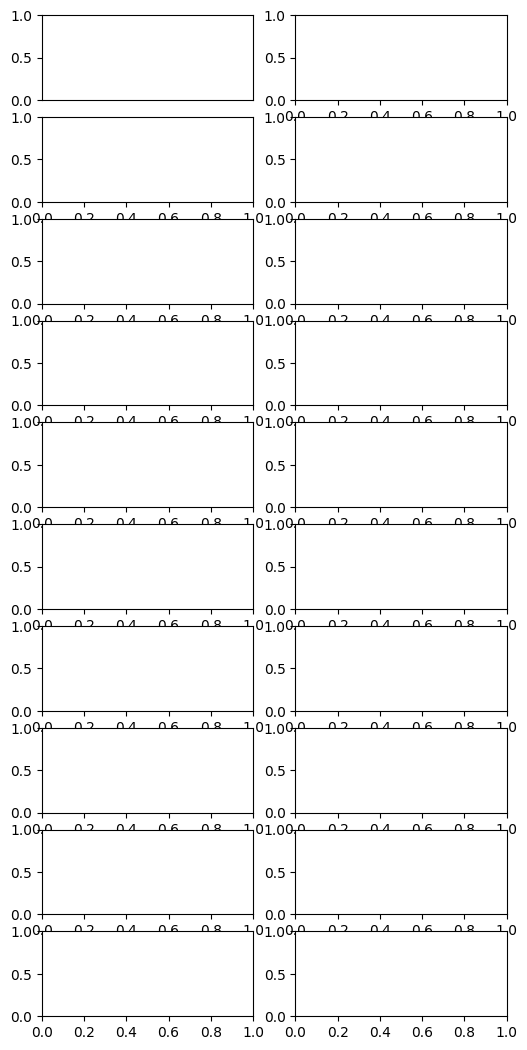

In [20]:
dicts = {
    "mimic": read_msgpack(mimic_dict_path)["regular"], # all mimic codes
    "stanford": read_msgpack(stanford_dict_path)["regular"] # these are the Stanford codes used
}

p1 = "mimic"
p2 = "stanford"

p1_dict = dicts[p1]
p2_dict = dicts[p2]
selected_codes = codes[:20]
code_ranges = {}
for r, code in enumerate(selected_codes):
    # get all start and ends
    # get median with 90 percentile range 
    # plot ranges
    p1_ranges = flatten([
        [x["val_start"], x["val_end"]] 
        for x in p1_dict if x["code_string"]==code 
        if (x["val_start"]!=0 and x["val_end"]!=0)
    ])
    
    p2_ranges = flatten([
        [x["val_start"], x["val_end"]] 
        for x in p2_dict if x["code_string"]==code 
        if (x["val_start"]!=0 and x["val_end"]!=0)
    ])

    if not p1_ranges or not p2_ranges:
        continue

    p1_ranges.sort()
    p2_ranges.sort()

    code_ranges[code] = {
        p1: [p1_ranges[1], p1_ranges[-2]],
        p2: [p2_ranges[1], p2_ranges[-2]],
    }

fig, axes = plt.subplots(nrows=int(len(code_ranges)/2), ncols=2, figsize=(3*2, 0.65*len(code_ranges)))
it = 0
for code, ranges in code_ranges.items():
    r, c = it//2, it%2
    axes[r][c].add_patch(Rectangle([ranges[p1][0], 0.5], ranges[p1][1]-ranges[p1][0], 0.5, color="dodgerblue"))
    axes[r][c].add_patch(Rectangle([ranges[p2][0], 1.5], ranges[p2][1]-ranges[p2][0], 0.5, color="crimson"))


    axes[r][c].get_xaxis().set_visible(False)
    x_min = min(ranges[p1] + ranges[p2]) - min(ranges[p1] + ranges[p2])*0.1 
    x_max = max(ranges[p1] + ranges[p2]) + max(ranges[p1] + ranges[p2])*0.1
    axes[r][c].set_xlim([x_min, x_max])

    axes[r][c].set_ylim([-0.5, 3])
    axes[r][c].set_yticklabels([])
    axes[r][c].set_yticks([])
    axes[r][c].set_ylabel(code.replace("/", "\n"))

    for side in ["right", "top", "bottom"]:
        axes[r][c].spines[side].set_visible(False)

    it+=1
    
plt.tight_layout()
plt.show()